# Boston Houses' prices prediction

In [20]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd

## Load in the data

In [21]:
!wget https://lazyprogrammer.me/course_files/exercises/boston.txt

--2025-04-05 22:21:30--  https://lazyprogrammer.me/course_files/exercises/boston.txt
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: 'boston.txt.1'

     0K .......... .......... .......... .......... .......... 25,4M
    50K                                                        1,04G=0,002s

2025-04-05 22:21:31 (25,5 MB/s) - 'boston.txt.1' saved [51256]



### Process the text file

In [22]:
def create_csv_file(in_file, out_file):
    with open(out_file, 'w') as out_f:
        with open(in_file, 'r') as in_f:
            i = 22  # Number of line to skips
            count = 0
            for line in in_f:
                if i == 0:
                    data = line.strip().split(" ")
                    if len(data) == 0: continue
                    # Write to output file
                    for num in data:
                        # Skip non-numeric fields (due to split by just a whitespace)
                        if len(num) == 0: continue
                        out_f.write(num.strip())
                        count += 1
                        if count != 14:
                            out_f.write(',')
                        # Finished reading a row, move to next line
                        else:
                            count = 0
                            out_f.write('\n')
                
                # Skip line 
                else: i -= 1

In [23]:
# Create a csv file with the data only
create_csv_file("boston.txt", "boston.csv")

### Read csv file into a numpy array

In [24]:
data = pd.read_csv("boston.csv", header=None).to_numpy(dtype=np.float32)

In [128]:
X = data[:, :12]  # The first 12 fields are features
inputs = X.copy()
y = data[:, 13].reshape(-1, 1)  # the last field is the price
outputs = y.copy()

In [129]:
# Verify shape
X.shape, y.shape

((506, 12), (506, 1))

#### Processing the data

1. Standardize
2. Convert into torch Tensor 
3. Split into test set and training set

In [130]:
# Standardize data
mu_X = X.mean(axis=0)
sigma_X = X.std(axis=0)
mu_y = y.mean()
sigma_y = y.std()

X = (X - mu_X) / sigma_X
y = (y - mu_y) / sigma_y

In [131]:
X = torch.from_numpy(X)  # Already of type float32 
y = torch.from_numpy(y)

In [132]:
# Number of training samples
num_train = 5 * X.shape[0] // 6

X_train, X_test = torch.split_with_sizes(X, [num_train, X.shape[0] - num_train])
y_train, y_test = torch.split_with_sizes(y, [num_train, y.shape[0] - num_train])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([421, 12]),
 torch.Size([85, 12]),
 torch.Size([421, 1]),
 torch.Size([85, 1]))

### Initiate the model

For now assume linear model

In [133]:
model = nn.Linear(12, 1)

In [134]:
# Configure loss function and optimizer
lr = 0.05

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Train the model

In [135]:
# Number of epochs
num_epochs = 70
losses = []

for epoch in range(num_epochs):
    # Zero the gradient
    optimizer.zero_grad()
    
    # Forward pass and calculate the loss
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)
    
    losses.append(loss.item())  # Record for examination
    
    # Backward pass and apply the gradient
    loss.backward()
    optimizer.step()
    
    # Print the  progress every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: loss={loss.item()}")

Epoch 0: loss=3.102670431137085
Epoch 5: loss=0.6914450526237488
Epoch 10: loss=0.5179481506347656
Epoch 15: loss=0.44814056158065796
Epoch 20: loss=0.4140084385871887
Epoch 25: loss=0.39491501450538635
Epoch 30: loss=0.3831042945384979
Epoch 35: loss=0.37519851326942444
Epoch 40: loss=0.36957135796546936
Epoch 45: loss=0.36537763476371765
Epoch 50: loss=0.3621465861797333
Epoch 55: loss=0.35959750413894653
Epoch 60: loss=0.3575521409511566
Epoch 65: loss=0.3558904826641083


### Tesing the model

In [136]:
# Test the model on the test set
#* Technically, we want a validation set as well
y_test_hat = model(X_test).detach()
print(criterion(y_test_hat, y_test).item())

0.2674988806247711


#### Examine the parameters

In [144]:
print(f"Weights: {model.weight.data.numpy()}\nBias: {model.bias.data.numpy()}")

Weights: [[-0.16297401  0.04216408 -0.03866151  0.07814648 -0.15269761  0.53431267
  -0.12611422 -0.22333665  0.21221976 -0.10414128 -0.2139368   0.06156142]]
Bias: [0.05593902]


#### Plotting out the loss through epochs

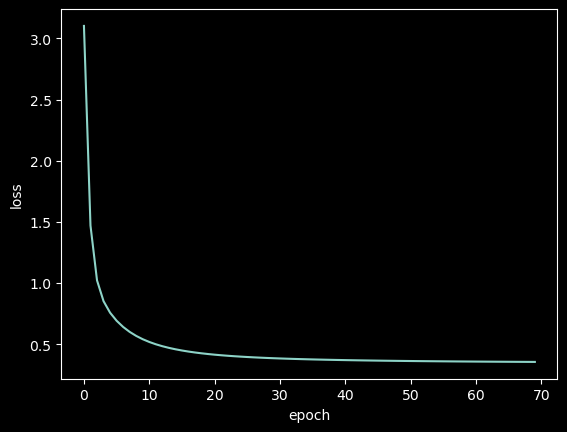

In [138]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(losses)
plt.show()

### Change the scale of the model's output to account for the standardization

**Assumptions**: the mean and std of the training set is std of the population.

Note that we have $${{y-\mu_y}\over\sigma_y} = {{\bold{x}-\mu_{\bold{x}}}\over\sigma_{\bold{x}}} \cdot \bold{w} + b$$
Then, we get $$y = \mu_y + \sigma_y{\bold{x}\cdot\bold{w}-\mu_{\bold{x}}\over\sigma_{\bold{x}}} + b\sigma_y$$

In [180]:
def model_scaled(X):
    return (mu_y + sigma_y*(((X-mu_X)/sigma_X) @ model.weight.data.numpy().T) + model.bias.data.numpy() * sigma_y)

In [189]:
# Real loss (in terms of dollars)
(1/outputs.shape[0]) * np.sqrt(np.abs(model_scaled(inputs[402:])**2 - outputs[402:]**2).sum()) * 1000

240.80413697736535